In [ ]:
!pip install pyupbit
import pandas as pd
import numpy as np
import datetime
import pyupbit
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation, Conv1D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.losses import Huber
from keras.optimizers import Adam
import datetime
import requests
from bs4 import BeautifulSoup

In [ ]:
def crawller(code, time):
    req = requests.get(
        f"https://crix-api-endpoint.upbit.com/v1/crix/candles/minutes/{time}?code=CRIX.UPBIT.KRW-{code}&count=400"
    )
    data = req.json()
    result = []

    for i, candle in enumerate(data):
        result.append(
            {
                "Time": data[i]["candleDateTimeKst"],
                "OpeningPrice": data[i]["openingPrice"],
                "HighPrice": data[i]["highPrice"],
                "LowPrice": data[i]["lowPrice"],
                "TradePrice": data[i]["tradePrice"],
                "CandleAccTradeVolume": data[i]["candleAccTradeVolume"],
                "candleAccTradePrice": data[i]["candleAccTradePrice"],
            }
        )

    coin_data = pd.DataFrame(result)
    return coin_data

def normalize_windows(data):
    normalized_data = []

    for window in data: #3
        normalized_windows=[]

        for jdx in range(data.shape[-1]): #5
            normalized_window=[]

            for idx in range(data.shape[1]): #11
                # print(window[:,idx][jdx],window[0,idx])

                normalized_window.append((float(window[:,jdx][idx]) / (float(window[0,jdx])+0.000001)) - 1)

            normalized_windows.append(normalized_window)

        normalized_data.append(np.array(normalized_windows).T)

    return np.array(normalized_data)

# Load Data

In [ ]:
code = "KRW-BTC"

data_path = "/content/Bitcoin - 비트코인 과거 데이터 - Investing.com (1).csv"
# data_path = '/content/Ethereum - 이더리움 과거 데이터 - Investing.com (1).csv'
# data_path = '/content/Polkadot 과거 데이터 - Investing.com.csv'

data = pd.read_csv(data_path)

data.head()

,날짜,종가,오픈,고가,저가,거래량,변동 %
0,2021년 02월 26일,"47,736.1","46,928.5","48,413.9","44,248.2",195.93K,1.72%
1,2021년 02월 25일,"46,928.5","49,695.9","52,013.8","46,773.7",83.22K,-5.57%
2,2021년 02월 24일,"49,697.5","48,911.1","51,311.8","47,031.7",153.75K,1.61%
3,2021년 02월 23일,"48,911.2","54,114.1","54,115.0","45,093.8",315.07K,-9.61%
4,2021년 02월 22일,"54,111.8","57,437.6","57,480.8","48,353.8",244.95K,-5.78%


# Data Preprocessing

In [ ]:
data['변동 %'] = data['변동 %'].str.replace('%', '')

for i in data.columns:
    data[i]=data[i].str.replace(',' , '')

idx_null = data[data['거래량']=='-'].index
data=data.drop(idx_null)

for idx, value in zip(data['거래량'].index, data['거래량'].values):
    if value[-1] == 'K':
        data['거래량'][idx]=float(value.replace('K',''))*1000
    elif value[-1] == 'M':
        data['거래량'][idx]=float(value.replace('M',''))*1000000

data = data.sort_values(by=["날짜"], axis=0)

data.tail()

,날짜,종가,오픈,고가,저가,거래량,변동 %
4,2021년 02월 22일,54111.8,57437.6,57480.8,48353.8,244950,-5.78
3,2021년 02월 23일,48911.2,54114.1,54115.0,45093.8,315070,-9.61
2,2021년 02월 24일,49697.5,48911.1,51311.8,47031.7,153750,1.61
1,2021년 02월 25일,46928.5,49695.9,52013.8,46773.7,83220,-5.57
0,2021년 02월 26일,47736.1,46928.5,48413.9,44248.2,195930,1.72


# Split X, Y and Create Windowed X

In [ ]:
WINDOW = 30


X_data = data.drop(['오픈'],axis='columns')
X_data = X_data.iloc[:, 1:2] # 종가, 고가, 저가, 거래량, 변동
print(X_data.columns)


result = []
for index in range(len(X_data) - WINDOW-1):
    result.append(X_data[index : index + WINDOW+1])

result=np.asarray(result).astype('float32')

final_result=normalize_windows(result)

row = int(round(final_result.shape[0] * 0.9))
train = final_result[:row, :]
np.random.shuffle(train)

x_train = train[:, :-1]
y_train = train[:, -1,0].reshape(-1,1)

x_test = result[row:, :-1]
y_test = result[row:, -1,0].reshape(-1,1)

print(x_train.shape,y_train.shape)

Index(['종가'], dtype='object')
(1668, 30, 1) (1668, 1)


In [ ]:
model = Sequential()

model.add(Conv1D(filters=32, kernel_size=WINDOW,
           padding="causal",
           activation="sigmoid",
           input_shape=[WINDOW, x_train.shape[-1]])
        )

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(rate=0.5))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.5))

model.add(LSTM(32, return_sequences=False))

model.add(Dense(1))

loss = Huber()
optimizer = Adam(0.0001)
model.compile(loss=Huber(), optimizer=optimizer, metrics=["mse"])
model.summary()

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_31 (Conv1D)           (None, 30, 32)            992       
_________________________________________________________________
lstm_96 (LSTM)               (None, 30, 128)           82432     
_________________________________________________________________
dropout_67 (Dropout)         (None, 30, 128)           0         
_________________________________________________________________
lstm_97 (LSTM)               (None, 30, 64)            49408     
_________________________________________________________________
dropout_68 (Dropout)         (None, 30, 64)            0         
_________________________________________________________________
lstm_98 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dense_34 (Dense)             (None, 1)               

In [ ]:
start_time = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")



history=model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    epochs=100,
    verbose=-1,
    callbacks=[
        # ModelCheckpoint(
        #     ".\\models\\%s_eth.h5" % (start_time),
        #     monitor="val_loss",
        #     verbose=False,
        #     save_best_only=True,
        #     mode="auto",
        # ),
        ReduceLROnPlateau(
            monitor="val_loss", factor=0.2, patience=5, verbose=0, mode="auto"
        ),
        EarlyStopping(monitor="val_loss", patience=5)
    ]
)

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100


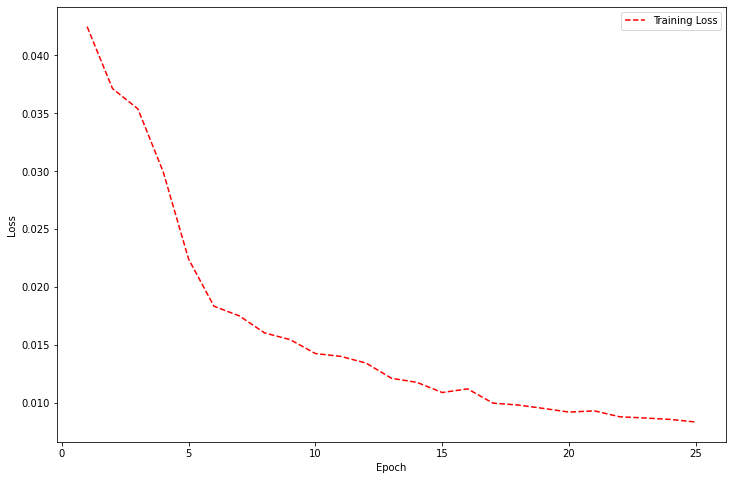

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
epoch_count = range(1, len(loss) + 1)
plt.figure(figsize=(12,8))
plt.plot(epoch_count, loss, 'r--')
plt.legend(['Training Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

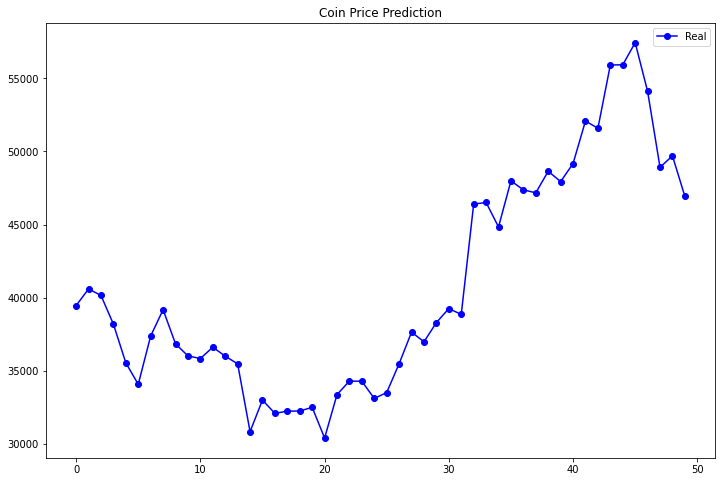

In [ ]:
pred = model.predict(x_test)
plt.figure(figsize=(12,8))
plt.plot(y_test[-50:], color='blue', label='Real',marker='o')
# plt.plot(pred[-50:], color='red', label='Prediction',marker='*')
plt.title('Coin Price Prediction')
plt.legend()
plt.show()

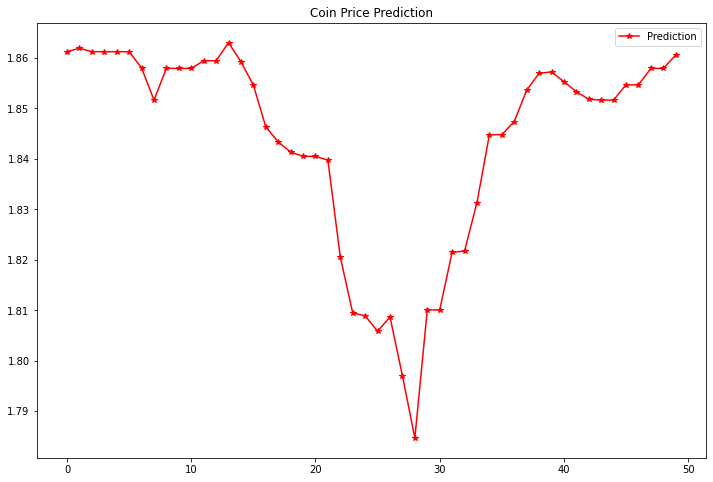

In [ ]:
pred = model.predict(x_test)
plt.figure(figsize=(12,8))
# plt.plot(y_test[-50:], color='blue', label='Real',marker='o')
plt.plot(pred[-50:], color='red', label='Prediction',marker='*')
plt.title('Coin Price Prediction')
plt.legend()
plt.show()